In [13]:
# Click into this cell and press shift-enter before using this notebook.
# This line loads the ability to use %%ai in your file
%load_ext jupyter_ai_magics
# These lines import the Python modules we commonly use in CMPSC 5A
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots

# Lecture 9, CMPSC 5A, S25

Tue 04/29/2025, Week 5

## A weird bug!

Here's a weird bug that someone had with their code during office hours.

It came up in the context of lab02, so I've changed some of the details to not give away answers, but it's pretty similar.



In [16]:
courseTable = Table.read_table("data/ucsb-s25-courses.csv")

In [17]:
def courseIdToDept(courseId):
    return courseId[0:8].strip()

def courseIdToCourseNum(courseId):
    return courseId[8:13].strip()

def courseIdToSuffix(courseId):
    return courseId[14:].strip()

def isLecture(sectionNum):
    # if section number is divisible by 100, it's a lecture
    return sectionNum % 100 == 0

In [18]:
courses = courseTable.with_columns(
    "dept", courseTable.apply(courseIdToDept, 0),
    "courseNum", courseTable.apply(courseIdToCourseNum, 0),
    "suffix", courseTable.apply(courseIdToSuffix, 0),
    "isLecture", courseTable.apply(isLecture, "SECTION")
)


In [19]:
csLectures = courses \
   .where("dept",are.equal_to("CMPSC")) \
   .where("isLecture",are.equal_to(True)) \
   .where("STATUS",are.not_equal_to("Closed")).show(4) 

COURSEID,ENROLLED,GES,INSTRUCTOR,MAXENROLL,QUARTER,SECTION,STATUS,dept,courseNum,suffix,isLecture
CMPSC 5A -1,128,"C (L&S), QNT (L&S)",CONRAD P T,150,20252,100,nan,CMPSC,5A,1,True
CMPSC 9 -1,166,nan,KHARITONOVA Y,300,20252,100,nan,CMPSC,9,1,True
CMPSC 24 -1,146,nan,MIRZA D,149,20252,100,nan,CMPSC,24,1,True
CMPSC 32 -1,133,nan,NASIR N,150,20252,100,nan,CMPSC,32,1,True


In [20]:
csLectures.group("INSTRUCTOR")

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
csLectures

Wait what?  What happened?

Here's what we had before:

In [ ]:
csLectures = courses \
   .where("dept",are.equal_to("CMPSC")) \
   .where("isLecture",are.equal_to(True)) \
   .where("STATUS",are.not_equal_to("Closed")).show(4) 

In [ ]:
csLectures

Why?!!  This leads us to explore "print" vs. "return"

## Print vs. Return

Let's look at two function definitions:

In [ ]:
def addNumbers(a, b):
    return a + b

def sumNumbers(a, b):
    print(a + b)

Suppose we use call expressions with each of these:

In [ ]:
addNumbers(3, 5)

In [ ]:
sumNumbers(3, 5)

It looks like they are the same!  But they are not!

One way to see the difference is what happens when we assign the result.  Let's look at the values, and the types we get back:

In [ ]:
result1 = addNumbers(3,5)
result1

In [ ]:
type(result1)

In [ ]:
result2 = sumNumbers(3,5)

In [ ]:
result2

In [ ]:
type(result2)

Let's summarize that so we don't have to keep scrolling up and down to see the results:

<table>
    <thead>
        <tr>
            <th>With Return</th>
            <th>With Print</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td markdown="1">
<pre>
def addNumbers(a, b):            
    return a + b
</pre>
            </td>
            <td markdown="1">
<pre>
def sumNumbers(a, b):         
    print(a + b)
</pre>
            </td>
        </tr>
        <tr>
            <td>return doesn't require ( ) </td>
            <td>print requires ( ) </td>
        </tr>
          <tr>
            <td>Assigning to variable <em>works</em>; the sum is <em>returned</em></td>
            <td>Assigning to a variable <em>doesn't work</em>; <code>None</code> is returned</td>
        </tr>
    </tbody>
</table>

## *Every* function returns a value, but it's sometimes `None`



One way to understand this more easily is if you memorize this rule:
* If a function encounters a `return` statement, the expression after the `return` is what we *get* as the *result* of the function call, i.e. the value we can assign to a variable.
* If a function *has not return* statement, then at the end, there is an implied statement like this:
  ```
  return None
  ```


As a result, this is what happens:
<table>
    <thead>
        <tr>
            <th>If you write this function:</th>
            <th>What you get is actually this function:</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td markdown="1">
<pre>
def sumNumbers(a, b):         
    print(a + b)
</pre>
            </td>
            <td markdown="1">
<pre>
def sumNumbers(a, b):         
    print(a + b)
    return None
</pre>
            </td>
        </tr>
        <tr>
            <td>A function with no explicit <code>return</code> statement... </td>
            <td>... turns into one with <code>return None</code> as the last line </td>
        </tr>
    </tbody>
</table>


That doesn't mean that functions that `return None` are bad, or useless!  

It just means we have to be aware of this behavior.

    



### The `.show()` function of the `Table()` object returns `None`

That's why this doesn't do what we want:

In [28]:
csLectures = courses \
   .where("dept",are.equal_to("CMPSC")) \
   .where("isLecture",are.equal_to(True)) \
   .where("STATUS",are.not_equal_to("Closed")).show(4) 
csLectures.barh("COURSEID","ENROLLED")

COURSEID,ENROLLED,GES,INSTRUCTOR,MAXENROLL,QUARTER,SECTION,STATUS,dept,courseNum,suffix,isLecture
CMPSC 5A -1,128,"C (L&S), QNT (L&S)",CONRAD P T,150,20252,100,nan,CMPSC,5A,1,True
CMPSC 9 -1,166,nan,KHARITONOVA Y,300,20252,100,nan,CMPSC,9,1,True
CMPSC 24 -1,146,nan,MIRZA D,149,20252,100,nan,CMPSC,24,1,True
CMPSC 32 -1,133,nan,NASIR N,150,20252,100,nan,CMPSC,32,1,True


AttributeError: 'NoneType' object has no attribute 'barh'

## What's the fix?

The fix is to remove the `.show(4)` method from the end of the chain.

We can chain the `.where(...)` method calls because each of them *returns* a new Table object.

But show(4) returns `None` so that's why we get the error `'NoneType' object has no attribute 'barh'`

Here's that code where we remove the `show(4)` from the end of the chain, and
put it on a separate line.

Now the bar graph works!

COURSEID,ENROLLED,GES,INSTRUCTOR,MAXENROLL,QUARTER,SECTION,STATUS,dept,courseNum,suffix,isLecture
CMPSC 5A -1,128,"C (L&S), QNT (L&S)",CONRAD P T,150,20252,100,nan,CMPSC,5A,1,True
CMPSC 9 -1,166,nan,KHARITONOVA Y,300,20252,100,nan,CMPSC,9,1,True
CMPSC 24 -1,146,nan,MIRZA D,149,20252,100,nan,CMPSC,24,1,True
CMPSC 32 -1,133,nan,NASIR N,150,20252,100,nan,CMPSC,32,1,True


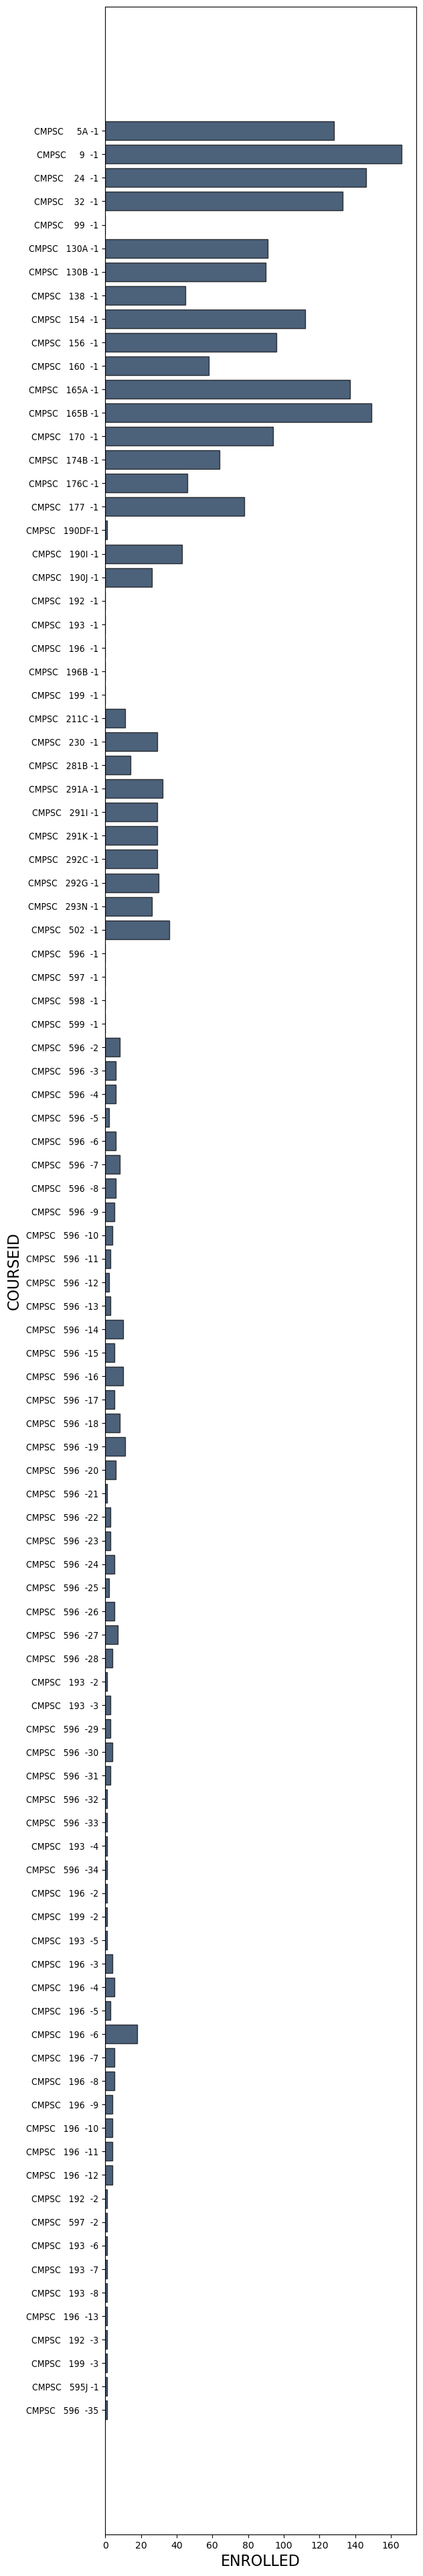

In [27]:
csLectures = courses \
   .where("dept",are.equal_to("CMPSC")) \
   .where("isLecture",are.equal_to(True)) \
   .where("STATUS",are.not_equal_to("Closed"))
csLectures.show(4)
csLectures.barh("COURSEID","ENROLLED")

# But what if I wanted just a bar graph for first four courses?

So we had this code, and it worked, but what we got was:

* A display of the top four rows in the table
* A bar graph of ALL of the courses in the table

```python
csLectures = courses \
   .where("dept",are.equal_to("CMPSC")) \
   .where("isLecture",are.equal_to(True)) \
   .where("STATUS",are.not_equal_to("Closed"))
csLectures.show(4)
csLectures.barh("COURSEID","ENROLLED")
```

What if we wanted a bar graph of just the first four rows in the table?

That's where we need to understand the difference between `show(4)` and `take([0,1,2,3])`

* `.show(4)` means "show me the first four rows in the table, but leave the table unchanged".
  - It's similar to `print` in that it just *displays* something on the *screen* but that's *all* it does.
  - And, after it displays, we get *nothing* back that we can assign or work with.
* `take([0,1,2,3])` by contrast, *gives us something back*: a new table with the rows 0, 1, 2 and 3.
  - Remember that the row numbers start at 0, not at 1.
  - So, the row numbers of the first four rows are 0,1,2,3

Here's what that looks like; notice a few things:
* Note that we *can* chain the take to the end of the chain of where's
* Note that we can assign the result to the variable `csLectures`
* And notice that when we use that variable with the `barh`, we get only the first four courses.

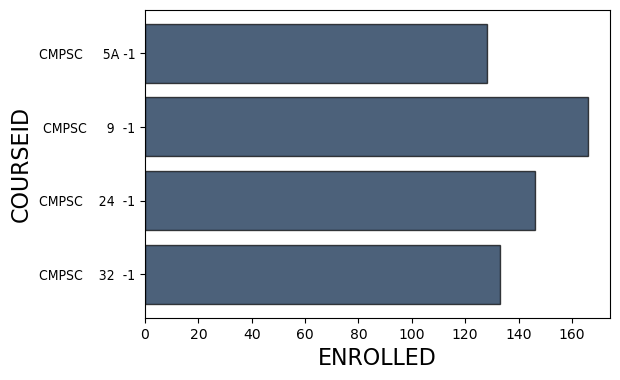

In [31]:
csLectures = courses \
   .where("dept",are.equal_to("CMPSC")) \
   .where("isLecture",are.equal_to(True)) \
   .where("STATUS",are.not_equal_to("Closed")) \
   .take([0,1,2,3])
csLectures.barh("COURSEID","ENROLLED")

## We often use `np.arange(...)` instead of a list of specific numbers

In this code, we used `[0,1,2,3]`, a list of four integers, to specify the row numbers.

#### But, it's more common to use `np.arange(4)` which gives us this automatically:

In [33]:
np.arange(4)

array([0, 1, 2, 3])

Compare these two ways of specifying *take the first four rows*:

<table>
    <thead>
        <tr>
            <th><code>take()</code> argument is <code>[0,1,2,3]</code></th>
            <th><code>take()</code> argument is <code>np.arange(4)</code></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td >
<pre>
csLectures = courses \
   .where("dept",are.equal_to("CMPSC")) \
   .where("isLecture",are.equal_to(True)) \
   .where("STATUS",are.not_equal_to("Closed")) \
   .take([0,1,2,3])
csLectures.barh("COURSEID","ENROLLED")
</pre>
            </td>
            <td>
<pre>
csLectures = courses \
   .where("dept",are.equal_to("CMPSC")) \
   .where("isLecture",are.equal_to(True)) \
   .where("STATUS",are.not_equal_to("Closed")) \
   .take(np.arange(4))
csLectures.barh("COURSEID","ENROLLED")
</pre>
</td>
</tr>
</tbody>
</table>



Though this both do the same thing:
* The `np.arange(4)` is preferred because it gets right to the point: we want the first four rows.
* Coding is about ore than just getting the right result; it's about writing the code in a way that in the future, both *you* and *other people* can read the code and understand it.


## Why it is important to be able to understand the code

It's understandable that at first, you may just be focused on *getting the result* and not on whether code is readable/understandable.

But, readability/understandability are important for many reasons; here are two:
* _Reliability_: If people will be relying on your data, tables, and visualizations (charts and graphs), you want to be sure they are accurate. That means you need to be able to read the code to be *sure* it's working as intended.
* _Reuse_: You, or others, may need to do similar data analysis in the future, and you may want to look back at code you've already written to use it as a model for some new code.   If the code is hard to understand, that will be harder to accomplish.

### Back to print vs return



One of the advantages of functions that return values is that we can use the values they return in a new expression.

For example:

In [2]:
def addNumbers(a, b):
    return a + b

# Multiplies 2+3 times 3+4
# That is 5 times 7, giving 35
x = addNumbers(2,3) * addNumbers(3,4)
x

35

BUT this doesn't work if you try it with functions that just *print* the sum:

In [4]:
def sumNumbers(a, b):
    print(a + b)

# This does *not* multiply 2+3 times 3+4
# It prints 5 and prints 7
# But each part returns None and you can't multiply None * None
x = sumNumbers(2,3) * sumNumbers(3,4)
x

5
7


TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

### Functions that return values can be nested:

In [6]:
x   = addNumbers(addNumbers(1,2), addNumbers(3,4))
# x = addNumbers(        3      ,       7.       )
# x =                     10
x

10

## Lists vs. Arrays

Let's compare two ways of grouping things in Python: lists and arrays

| Lists | Arrays |
|-------|--------|
| Built in to Python | Requires `import numpy as np` | 
| Create with `[2, 3, 4]` |  Create with `make_array(2, 3, 4) `
| `type` returns `list`      | `type` returns `np.ndarray` |
| Can contain things of different types | Must all be the same type; will be coerced to string if you try different types |



In [8]:
# Example of lists

things = ["UCSB", True, 1944, 10.0]
type(things)

list

In [24]:
print(f"type(things[0])={type(things[0])}")
print(f"type(things[1])={type(things[1])}")
print(f"type(things[2])={type(things[2])}")
print(f"type(things[3])={type(things[3])}")

type(things[0])=<class 'str'>
type(things[1])=<class 'bool'>
type(things[2])=<class 'int'>
type(things[3])=<class 'float'>


In [9]:
nums = [4, 6, 23, 9]
nums

[4, 6, 23, 9]

In [11]:
schools = ["UCSB", "UCSD", "UCLA"]
schools

['UCSB', 'UCSD', 'UCLA']

In [16]:
# Examples of arrays

schools_array = make_array("UCSB", "UCSD", "UCLA")
type(schools_array)

numpy.ndarray

In [26]:
# If you try to make a numpy.ndarray with things of different types
# they all become strings
things_array = make_array("UCSB", True, 1944, 10.0)
things_array

array(['UCSB', 'True', '1944', '10.0'],
      dtype='<U32')

In [27]:
print(f"type(things_array[0])={type(things_array[0])}")
print(f"type(things_array[1])={type(things_array[1])}")
print(f"type(things_array[2])={type(things_array[2])}")
print(f"type(things_array[3])={type(things_array[3])}")

type(things_array[0])=<class 'numpy.str_'>
type(things_array[1])=<class 'numpy.str_'>
type(things_array[2])=<class 'numpy.str_'>
type(things_array[3])=<class 'numpy.str_'>


## What lists and arrays have in common

You can use either one to make a new column in a table. 

You can even mix and match:


In [31]:
abbreviations = ["UCSB","UCSD","UCLA"]
official_towns = make_array("Santa Barbara", "San Diego", "Los Angeles")
real_towns = ["Goleta", "La Jolla", "Westwood" ]

schools = Table().with_columns("Abbreviations",abbreviations,"Official",official_towns,"Real",real_towns)
schools

Abbreviations,Official,Real
UCSB,Santa Barbara,Goleta
UCSD,San Diego,La Jolla
UCLA,Los Angeles,Westwood


The main advantage of a numpy.ndarray is the math you can do with it

In [33]:
# This works
distances_in_miles = make_array(40, 28, 104)
times_in_minutes = make_array(60, 75, 98)
times_in_hours = times_in_minutes/60
times_in_hours

array([ 1.        ,  1.25      ,  1.63333333])

In [35]:
speeds_in_miles_per_hour = distances_in_miles / times_in_hours
speeds_in_miles_per_hour

array([ 40.        ,  22.4       ,  63.67346939])

### Divide a numpy.ndarray times a scalar

As you can see, we can treat numpy.ndarrays as *vectors*, i.e. a one-dimensional list of numbers.

A single number like `60` above is called a *scalar*.

When we divide a numpy.ndarray (vector) by a scalar, it "scales" the numbers like this:

```python
times_in_hours = times_in_minutes/60
```

So each element in `times_in_hours` is one of the elements of `times_in_minutes` divided by 60.

This also works with addition, subtraction and mutiplication:

In [41]:
nums = make_array(1, 2, 4)
bigger_nums = nums + 1
bigger_nums

array([2, 3, 5])

In [42]:
smaller_nums = nums - 1
smaller_nums

array([0, 1, 3])

In [43]:
much_bigger_nums = nums * 100
much_bigger_nums

array([100, 200, 400])

In [ ]:
### These same tricks do NOT work on plain old python lists

In [44]:
nums_list = [1, 2, 4]
bigger_nums_list = nums_list + 1
bigger_nums_list

TypeError: can only concatenate list (not "int") to list

In [47]:
# This works, but it doesn't do what you think it does
# (at least not if you expect to get back [3,6,13]
nums_list = [1, 2, 4]
bigger_nums_list = nums_list * 3
bigger_nums_list

[1, 2, 4, 1, 2, 4, 1, 2, 4]

That's right, multiplying a list by an integer just repeats the list multiple times.

So, lists are fine, but for doing math and calculations, `numpy.ndarrays` are often more convenient.

# Grouping and Pivots

Slides: <https://docs.google.com/presentation/d/1FYg-mE8X0H5X0BHUUGlYIc0MAM9WzX8CtoVWGIrrg9k/edit?usp=sharing>